In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from datetime import timedelta

In [2]:
paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_u3hc4_uwind_osc_1/shelf_dx_500_u3hc4_uwind_osc_1_avg.nc', 
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_hsimt_uwind_osc_1/shelf_dx_500_hsimt_uwind_osc_1_avg.nc']
 
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

#Print out the advection schemes. Should be MPDATA, MPDATA, U3HC4, HSIMT. First one is basecase
print(ds[0].attrs['NLM_TADV'],ds[1].attrs['NLM_TADV'],ds[2].attrs['NLM_TADV'])

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth


ADVECTION:   HORIZONTAL   VERTICAL     
temp:        MPDATA       MPDATA       
salt:        MPDATA       MPDATA       
dye_01:      MPDATA       MPDATA       
dye_02:      MPDATA       MPDATA       
dye_03:      MPDATA       MPDATA 
ADVECTION:   HORIZONTAL   VERTICAL     
temp:        Upstream3    Centered4    
salt:        Upstream3    Centered4    
dye_01:      Upstream3    Centered4    
dye_02:      Upstream3    Centered4    
dye_03:      Upstream3    Centered4 
ADVECTION:   HORIZONTAL   VERTICAL     
temp:        HSIMT        HSIMT        
salt:        HSIMT        HSIMT        
dye_01:      HSIMT        HSIMT        
dye_02:      HSIMT        HSIMT        
dye_03:      HSIMT        HSIMT


In [3]:
def norm_fgf(ds,grid):
    qs = ds.salt # tracer 'q' (here salt) at the surface

    dqdx = xroms.to_rho(grid.derivative(qs, 'X'),grid) # defined at rho-points
    dqdy = xroms.to_rho(grid.derivative(qs, 'Y'),grid)

    us = ds.u # surface velocity field
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'),grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'),grid)

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    # Ddelq2.coords['lon_rho'] = ds.coords['lon_rho']
    # Ddelq2.coords['lat_rho'] = ds.coords['lat_rho']
    Ddelq2.name = 'Frontogenesis function'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    # gradq2.coords['lon_rho'] = ds.coords['lon_rho']
    # gradq2.coords['lat_rho'] = ds.coords['lat_rho']
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nDGQ2 = (Ddelq2 / (gradq2 * ds.f)).isel(s_rho = -1)
    # nDGQ2.coords['lon_rho'] = ds.coords['lon_rho']
    # nDGQ2.coords['lat_rho'] = ds.coords['lat_rho']
    nDGQ2.name = r'Normalized Frontogenesis Function'
    return nDGQ2

def rel_vort(ds,grid):
    us = ds.u.isel(s_rho=-1) # surface velocity field
    vs = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'), grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'), grid)
    # Vorticity:  v_x - u_y
    zeta = (dvdx - dudy)/ds.f
    zeta.name = 'rvort'
    return zeta

In [4]:
fgf_sort = []
fgf_unsort = []
mnum_sort = []
mnum_unsort = []
mphy_sort = []
mphy_unsort = []
for i in range(len(paths)):
    zeta = rel_vort(ds[i],grid[i])
    fgf_u = norm_fgf(ds[i],grid[i])
    
    fgf_unsort.append(fgf_u) # Save unsorted
    
    fgf_s = fgf_u.where(zeta>1) # Save sorted 
    fgf_sort.append(fgf_s)
    
    mnum_u = np.log10(np.abs(ds[i].dye_03)) # Save unsorted 
    mnum_unsort.append(mnum_u)
    
    mnum_s = mnum_u.where(zeta>1) # Save sorted
    mnum_sort.append(mnum_s)
    
    mphy_u = np.log10(np.abs(grid[i].interp(ds[i].AKr,'Z'))) #Save unsorted
    mphy_unsort.append(mphy_u)
    
    mphy_s = mphy_u.where(zeta>1) # Save sorted 
    mphy_sort.append(mphy_s)

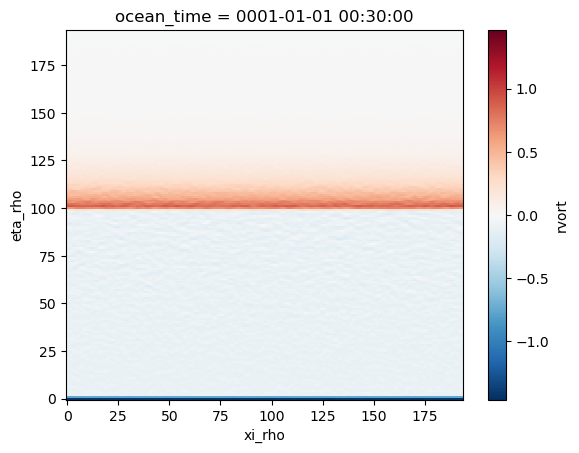

In [5]:
zeta = rel_vort(ds[0],grid[0])

zeta.isel(ocean_time=0).plot()

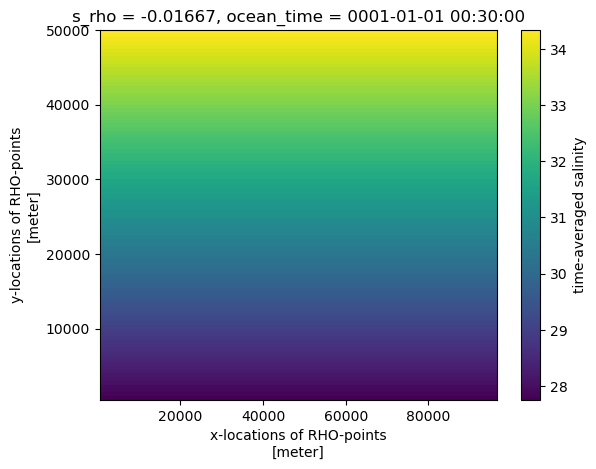

In [11]:
t = ds[0].y_rho.isel(xi_rho=xislice,eta_rho=etaslice)
t1 = ds[0].salt.isel(xi_rho=xislice,eta_rho=etaslice)[0,-1]
t1.plot(x = 'x_rho',y='y_rho')

In [16]:
print(t[-1,0].values, t1[-10:,0].values)

49750.0 [33.73228  33.79917  33.866276 33.9335   34.00031  34.067303 34.1343
 34.201344 34.26848  34.33527 ]


In [19]:
etaslice1 = slice(1,120)
t2 = ds[0].salt.isel(xi_rho=xislice,eta_rho=etaslice1)[0,-1]
print(t2[-10:,0].values)

[34.778492 34.799534 34.81859  34.835827 34.85143  34.86558  34.87837
 34.889923 34.900383 34.909863]


In [34]:
ds[0].z_rho.isel(xi_rho=xislice,eta_rho=etaslice)[0,0][-1,:].values

array([-50.18525972, -50.70164889, -51.34699125, -51.54274882,
       -50.1997058 , -50.52976546, -50.62439583, -50.55307131,
       -50.44150096, -50.62448869, -51.12519771, -49.74651132,
       -50.73349445, -49.84338371, -50.51261451, -50.93355302,
       -51.21302833, -51.16655864, -51.22731399, -51.18895392,
       -50.25977862, -50.89624553, -50.95625733, -50.35053638,
       -50.22492262, -51.21426774, -50.15423853, -51.39522222,
       -49.98805077, -50.42378402, -51.0140548 , -50.82363162,
       -51.04817791, -50.58889152, -51.09302238, -50.56479602,
       -50.13283781, -51.76134253, -50.45623604, -49.94931017,
       -49.81699818, -50.0505815 , -50.70394584, -50.96546593,
       -50.34857863, -51.12210175, -50.88494752, -51.11423763,
       -51.18457753, -49.76820199, -50.39256133, -50.40060688,
       -51.08560372, -51.03002401, -50.04508459, -50.38539474,
       -51.67646821, -51.18611848, -51.21272348, -50.97854781,
       -50.1658505 , -50.3397379 , -51.54522568, -50.16

In [7]:
tslice = slice(156,337)
xislice = slice(1,-1)
etaslice = slice(1,100)
fgf_bins = np.linspace(-3,5,151)
mnum_bins = np.linspace(-9,-3,151)

jpdf_unsort = []
mpdf_unsort = []
fpdf_unsort = []

jpdf_sort = []
mpdf_sort = []
fpdf_sort = []
for i in range(len(paths)):
    j_pdf = histogram(fgf_unsort[i].isel(ocean_time=tslice,xi_rho=xislice,eta_rho=etaslice), 
                      mnum_unsort[i].isel(ocean_time=tslice,s_rho=-1,xi_rho=xislice,eta_rho=etaslice),
                      bins=[fgf_bins, mnum_bins],density = True).compute()
    jpdf_unsort.append(j_pdf)
    
    m_pdf = histogram(mnum_unsort[i].isel(ocean_time=tslice,s_rho=-1,xi_rho=xislice,eta_rho=etaslice),
                      bins=[mnum_bins],density = True).compute()
    mpdf_unsort.append(m_pdf)
    
    f_pdf = histogram(fgf_unsort[i].isel(ocean_time=tslice,xi_rho=xislice,eta_rho=etaslice), 
                      bins=[fgf_bins],density = True).compute()
    fpdf_unsort.append(f_pdf)  
    
    #Sorted 
    j_pdf_sort = histogram(fgf_sort[i].isel(ocean_time=tslice,xi_rho=xislice,eta_rho=etaslice), 
                           mnum_sort[i].isel(ocean_time=tslice,s_rho=-1,xi_rho=xislice,eta_rho=etaslice),
                           bins=[fgf_bins, mnum_bins],density = True).compute()
    jpdf_sort.append(j_pdf_sort)
    
    m_pdf_sort = histogram(mnum_sort[i].isel(ocean_time=tslice,s_rho=-1,xi_rho=xislice,eta_rho=etaslice),
                           bins=[mnum_bins],density = True).compute()
    mpdf_sort.append(m_pdf_sort)
    
    f_pdf_sort = histogram(fgf_sort[i].isel(ocean_time=tslice,xi_rho=xislice,eta_rho=etaslice), 
                           bins=[fgf_bins],density = True).compute()
    fpdf_sort.append(f_pdf_sort)  

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/si

In [35]:
idx = jpdf_unsort[0].values.argmax(axis=1)
idx1 = jpdf_unsort[1].values.argmax(axis=1)
idx2 = jpdf_unsort[2].values.argmax(axis=1)

idx_sort = jpdf_sort[0].values.argmax(axis=1)
idx1_sort = jpdf_sort[1].values.argmax(axis=1)
idx2_sort = jpdf_sort[2].values.argmax(axis=1)

fgf_centers = 0.5*(fgf_bins[1:] + fgf_bins[:-1])
mnum_centers = 0.5*(mnum_bins[1:] + mnum_bins[:-1])

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'HSIMT')

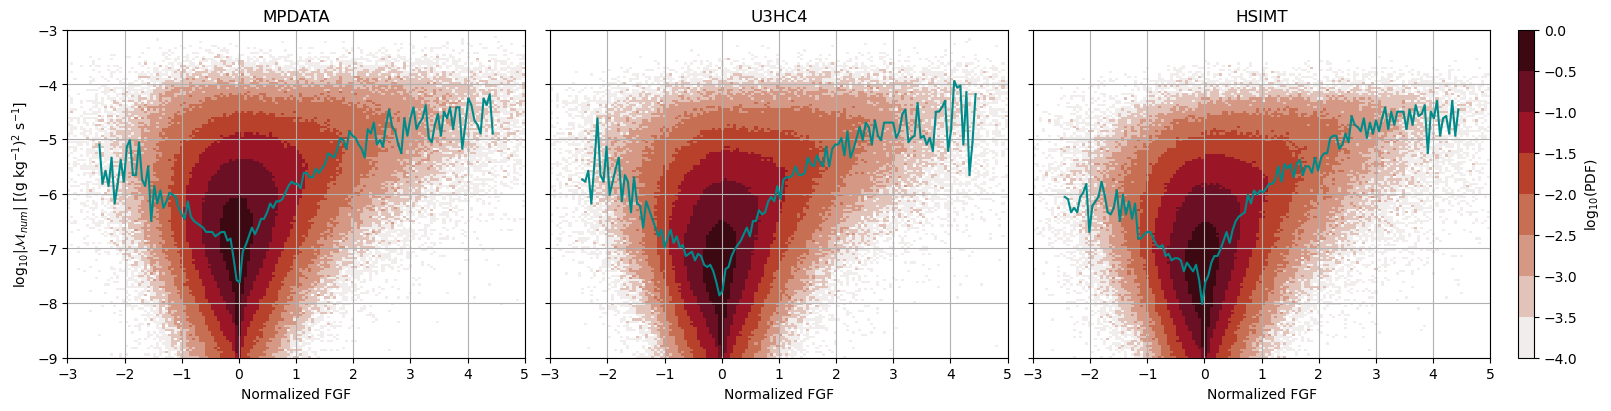

In [36]:
fig,ax = plt.subplots(1,3,figsize=(16,4), constrained_layout = True)

np.log10(jpdf_unsort[0]).plot(ax = ax[0],y='dye_03_bin', cmap = cmo.amp, add_colorbar = False, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))
np.log10(jpdf_unsort[1]).plot(ax = ax[1],y='dye_03_bin', cmap = cmo.amp, add_colorbar = False, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))
np.log10(jpdf_unsort[2]).plot(ax = ax[2],y='dye_03_bin', cmap = cmo.amp, cbar_kwargs={'label':r'log$_{10}$(PDF)'}, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))

ax[0].plot(fgf_centers[10:-10], mnum_centers[idx][10:-10], '-', color='darkcyan', lw=1.5)
ax[1].plot(fgf_centers[10:-10], mnum_centers[idx1][10:-10], '-', color='darkcyan', lw=1.5)
ax[2].plot(fgf_centers[10:-10], mnum_centers[idx2][10:-10], '-', color='darkcyan', lw=1.5)

# # plt.xlim(-1,1)
# plt.xlabel('Normalized FGF')
# plt.ylabel('log$_{10}|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')

for i in range(3):
    ax[i].grid()
    ax[i].set_xlabel('Normalized FGF')
    
ax[0].set_ylabel('log$_{10}|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[2].set_ylabel('')
ax[2].set_yticklabels('')

ax[0].set_title('MPDATA')
ax[1].set_title('U3HC4')
ax[2].set_title('HSIMT')

Text(0.5, 1.0, 'HSIMT')

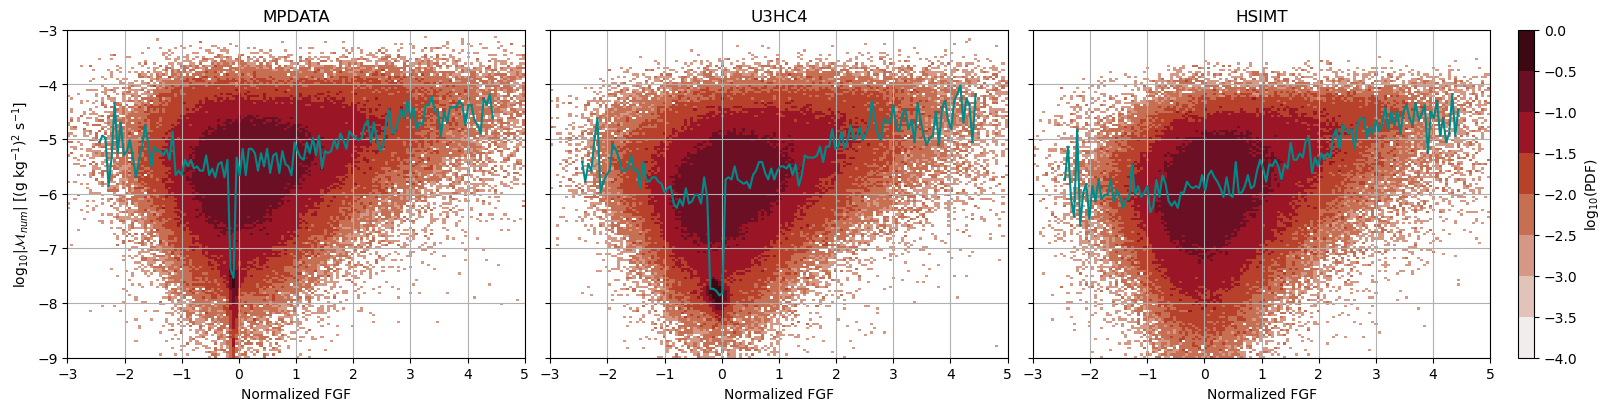

In [37]:
fig,ax = plt.subplots(1,3,figsize=(16,4), constrained_layout = True)

np.log10(jpdf_sort[0]).plot(ax = ax[0],y='dye_03_bin', cmap = cmo.amp, add_colorbar = False, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))
np.log10(jpdf_sort[1]).plot(ax = ax[1],y='dye_03_bin', cmap = cmo.amp, add_colorbar = False, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))
np.log10(jpdf_sort[2]).plot(ax = ax[2],y='dye_03_bin', cmap = cmo.amp, cbar_kwargs={'label':r'log$_{10}$(PDF)'}, vmin = -4, vmax = 0, levels = np.arange(-4,0.5,0.5))

ax[0].plot(fgf_centers[10:-10], mnum_centers[idx_sort][10:-10], '-', color='darkcyan', lw=1.5)
ax[1].plot(fgf_centers[10:-10], mnum_centers[idx1_sort][10:-10], '-', color='darkcyan', lw=1.5)
ax[2].plot(fgf_centers[10:-10], mnum_centers[idx2_sort][10:-10], '-', color='darkcyan', lw=1.5)

# # plt.xlim(-1,1)
# plt.xlabel('Normalized FGF')
# plt.ylabel('log$_{10}|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')

for i in range(3):
    ax[i].grid()
    ax[i].set_xlabel('Normalized FGF')
    
ax[0].set_ylabel('log$_{10}|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[2].set_ylabel('')
ax[2].set_yticklabels('')

ax[0].set_title('MPDATA')
ax[1].set_title('U3HC4')
ax[2].set_title('HSIMT')

/tmp/ipykernel_11134/2836327201.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{-9}$','$10^{-8}$','$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$'])


[Text(0, -9.0, '$10^{-9}$'),
 Text(0, -8.0, '$10^{-8}$'),
 Text(0, -7.0, '$10^{-7}$'),
 Text(0, -6.0, '$10^{-6}$'),
 Text(0, -5.0, '$10^{-5}$'),
 Text(0, -4.0, '$10^{-4}$'),
 Text(0, -3.0, '$10^{-3}$')]

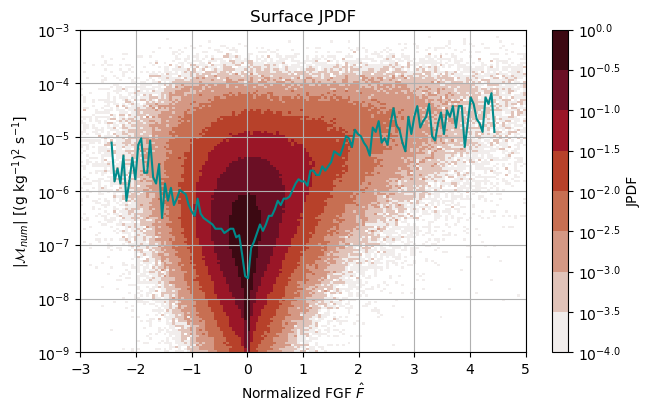

In [38]:
fig,ax = plt.subplots(1,1,figsize=(16/2.5,4), constrained_layout = True)

np.log10(jpdf_unsort[0]).plot(y='dye_03_bin', cmap = cmo.amp, 
                       cbar_kwargs={'label':r'JPDF', 'format':tick.FormatStrFormatter('$10^{%.1f}$')}, 
                       vmin = -4, vmax = 0, 
                       levels = np.arange(-4,0.5,0.5))

ax.plot(fgf_centers[10:-10], mnum_centers[idx][10:-10], '-', color='darkcyan', lw=1.5)

ax.grid()
ax.set_xlabel('Normalized FGF $\hat{F}$')
    
ax.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
ax.set_title(r'Surface JPDF')
ax.set_yticklabels(['$10^{-9}$','$10^{-8}$','$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$'])

# plt.savefig('mnum_fgf_jpdf.jpg', dpi = 300, bbox_inches='tight')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


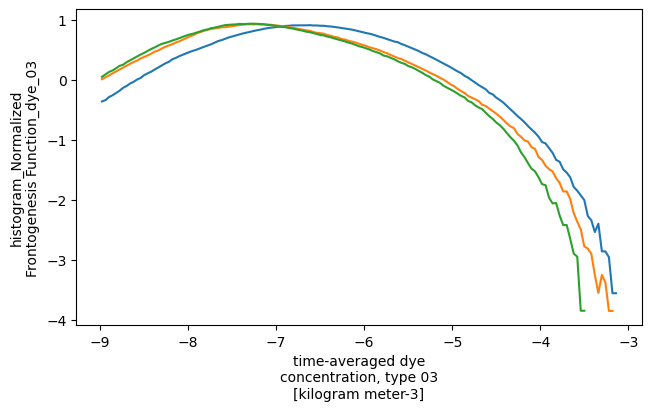

In [39]:
fig,ax = plt.subplots(1,1,figsize=(16/2.5,4), constrained_layout = True)

# np.log10(jpdf[0].sum(axis = 1)).plot()
np.log10(jpdf_unsort[0].sum(axis = 0)).plot()
np.log10(jpdf_unsort[1].sum(axis = 0)).plot()
np.log10(jpdf_unsort[2].sum(axis = 0)).plot()

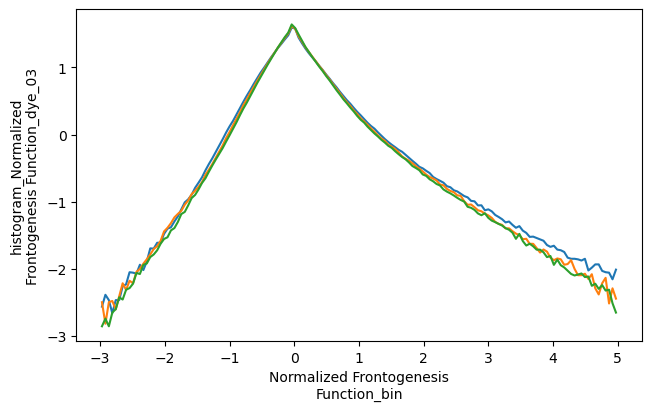

In [40]:
fig,ax = plt.subplots(1,1,figsize=(16/2.5,4), constrained_layout = True)

np.log10(jpdf_unsort[0].sum(axis = 1)).plot()
np.log10(jpdf_unsort[1].sum(axis = 1)).plot()
np.log10(jpdf_unsort[2].sum(axis = 1)).plot()
# np.log10(jpdf[0].sum(axis = 0)).plot()

# To do, turn this into a jointplot

In [41]:
from matplotlib.gridspec import GridSpec

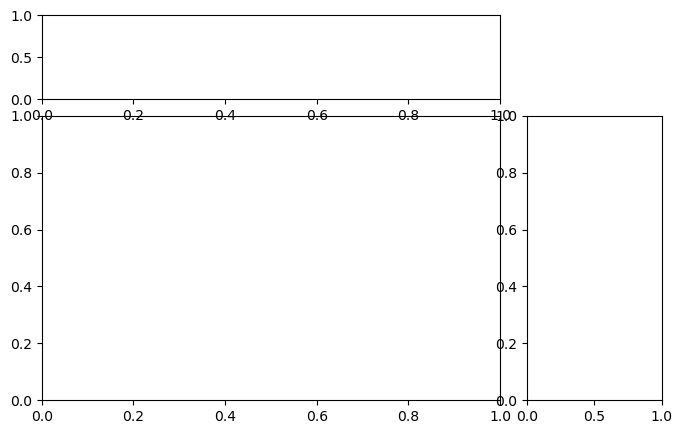

In [42]:
fig = plt.figure(figsize = (16/2,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

plt.show()

/tmp/ipykernel_11134/4186626063.py:8: RuntimeWarning: divide by zero encountered in log10
  d = axm.pcolormesh(jpdf_unsort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_unsort[0]['dye_03_bin'].values, np.log10((jpdf_unsort[0].T).values),


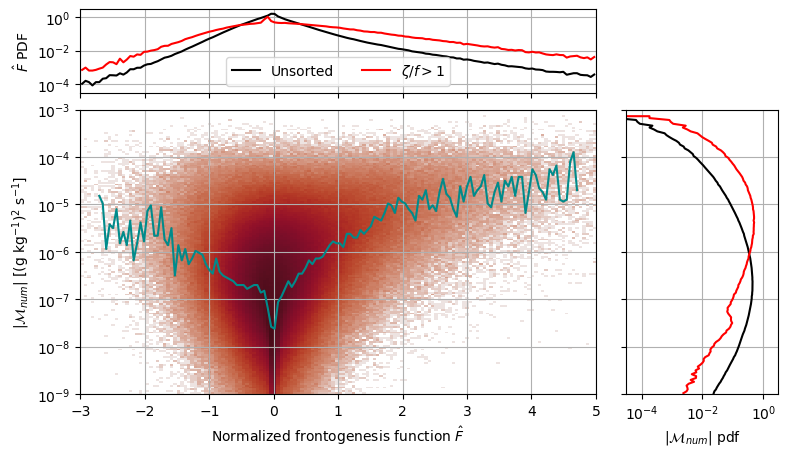

In [43]:
fig = plt.figure(figsize = (9,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

d = axm.pcolormesh(jpdf_unsort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_unsort[0]['dye_03_bin'].values, np.log10((jpdf_unsort[0].T).values),
             vmin = -4, vmax = 0,
             cmap = cmo.amp)

p=axm.plot(fgf_centers[5:-5], mnum_centers[idx][5:-5], '-', color='darkcyan', lw=1.5)

axm.grid()
axm.set_xticks([-3,-2,-1,0,1,2,3,4,5])
axm.set_yticks([-9,-8,-7,-6,-5,-4,-3])
axm.set_xlabel('Normalized frontogenesis function $\hat{F}$')
axm.set_ylim(-9,-3)
    
axm.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axm.set_yticklabels(['$10^{-9}$','$10^{-8}$','$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$'])

ax_t.semilogy(fpdf_unsort[0]['Normalized Frontogenesis Function_bin'], fpdf_unsort[0], lw = 1.5, c='k', label = 'Unsorted')
ax_t.semilogy(fpdf_sort[0]['Normalized Frontogenesis Function_bin'], fpdf_sort[0], lw = 1.5, c='r', label = r'$\zeta/f>1$')
ax_t.legend(ncol = 2)

ax_t.grid()
ax_t.set_xlim(-3,5)
ax_t.set_xticks([-3,-2,-1,0,1,2,3,4,5])
ax_t.set_yticks([10**-4,10**-2,10**-0])
ax_t.set_xticklabels('')
ax_t.set_ylim(10**-4.5,3)
ax_t.set_ylabel(r'$\hat{F}$ PDF')

ax_r.semilogx(mpdf_unsort[0],mpdf_unsort[0]['dye_03_bin'], lw = 1.5, c='k', label = 'Unsorted')
ax_r.semilogx(mpdf_sort[0],mpdf_sort[0]['dye_03_bin'], lw = 1.5, c='r', label = r'$\zeta/f>1$')
ax_r.set_yticks([-9,-8,-7,-6,-5,-4,-3])
ax_r.set_xticks([10**-4,10**-2,10**0])
ax_r.set_xlim(10**-4.5,3)
ax_r.set_ylim(-9,-3)
ax_r.grid()
ax_r.set_yticklabels('')
ax_r.set_xlabel(r'$|\mathcal{M}_{num}|$ pdf')
# ax_r.legend(ncol=1)

# plt.savefig('mnum_fgf_jpdf2.jpg', dpi = 400, bbox_inches='tight')
plt.show()

## Try adding in colorbar 

/tmp/ipykernel_11134/1372634622.py:10: RuntimeWarning: divide by zero encountered in log10
  d = axm.pcolormesh(jpdf_unsort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_unsort[0]['dye_03_bin'].values, np.log10((jpdf_unsort[0].T).values),


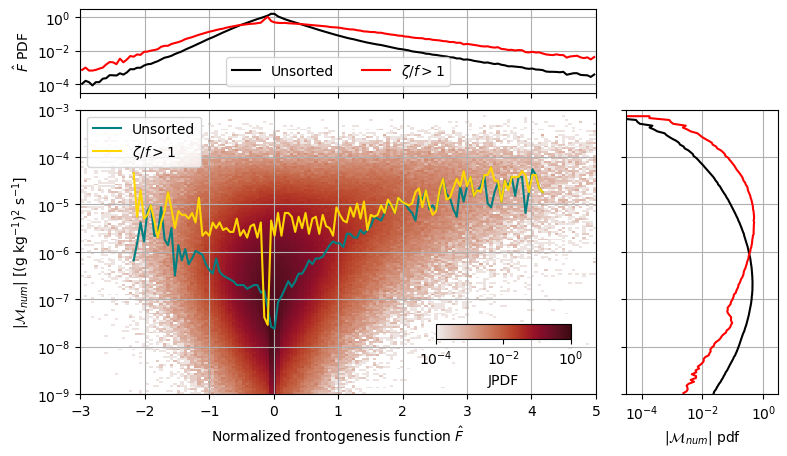

In [47]:
import matplotlib.ticker as tick

fig = plt.figure(figsize = (9,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

d = axm.pcolormesh(jpdf_unsort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_unsort[0]['dye_03_bin'].values, np.log10((jpdf_unsort[0].T).values),
             vmin = -4, vmax = 0,
             cmap = cmo.amp)

cax = fig.add_axes([0.52, 0.22, 0.15, 0.03])
fig.colorbar(d, cax=cax, orientation='horizontal', label = 'JPDF',format=tick.FormatStrFormatter('$10^{%d}$'))

p=axm.plot(fgf_centers[15:-15], mnum_centers[idx][15:-15], '-', color='teal', lw=1.5, label = 'Unsorted')
q = axm.plot(fgf_centers[15:-15], mnum_centers[idx_sort][15:-15], '-', color='gold', lw=1.5, label = r'$\zeta/f>1$')
axm.legend(loc = 'upper left')

axm.grid()
axm.set_xticks([-3,-2,-1,0,1,2,3,4,5])
axm.set_yticks([-9,-8,-7,-6,-5,-4,-3])
axm.set_xlabel('Normalized frontogenesis function $\hat{F}$')
axm.set_ylim(-9,-3)
    
axm.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axm.set_yticklabels(['$10^{-9}$','$10^{-8}$','$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$'])

ax_t.semilogy(fpdf_unsort[0]['Normalized Frontogenesis Function_bin'], fpdf_unsort[0], lw = 1.5, c='k', label = 'Unsorted')
ax_t.semilogy(fpdf_sort[0]['Normalized Frontogenesis Function_bin'], fpdf_sort[0], lw = 1.5, c='r', label = r'$\zeta/f>1$')
ax_t.legend(ncol = 2)

ax_t.grid()
ax_t.set_xlim(-3,5)
ax_t.set_xticks([-3,-2,-1,0,1,2,3,4,5])
ax_t.set_yticks([10**-4,10**-2,10**-0])
ax_t.set_xticklabels('')
ax_t.set_ylim(10**-4.5,3)
ax_t.set_ylabel(r'$\hat{F}$ PDF')

ax_r.semilogx(mpdf_unsort[0],mpdf_unsort[0]['dye_03_bin'], lw = 1.5, c='k', label = 'Unsorted')
ax_r.semilogx(mpdf_sort[0],mpdf_sort[0]['dye_03_bin'], lw = 1.5, c='r', label = r'$\zeta/f>1$')
ax_r.set_yticks([-9,-8,-7,-6,-5,-4,-3])
ax_r.set_xticks([10**-4,10**-2,10**0])
ax_r.set_xlim(10**-4.5,3)
ax_r.set_ylim(-9,-3)
ax_r.grid()
ax_r.set_yticklabels('')
ax_r.set_xlabel(r'$|\mathcal{M}_{num}|$ pdf')
# ax_r.legend(ncol=1)
# cb4 = fig.colorbar(m10, ax = ax[4,1], extend = 'both', label = r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]', format=tick.FormatStrFormatter('$10^{%d}$'))

plt.savefig('fig6_mnum_fgf_jpdf.jpg', dpi = 400, bbox_inches='tight')
plt.show()

## Now sort by the fronts and replot 

/tmp/ipykernel_11134/2098752527.py:8: RuntimeWarning: divide by zero encountered in log10
  d = axm.pcolormesh(jpdf_sort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_sort[0]['dye_03_bin'].values, np.log10((jpdf_sort[0].T).values),


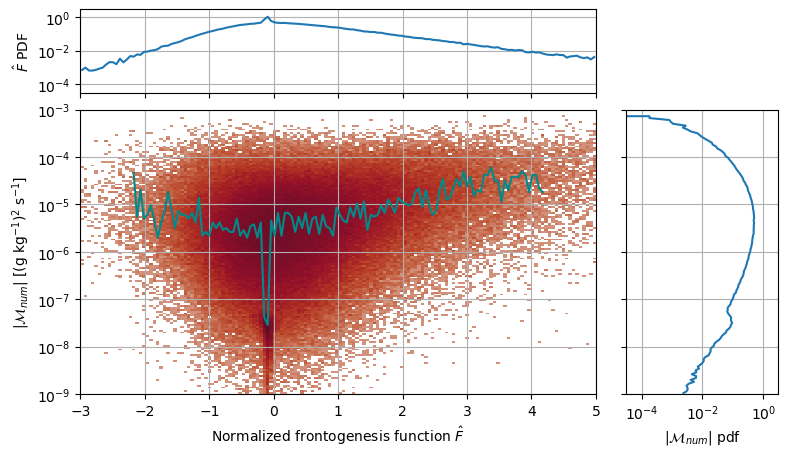

In [45]:
fig = plt.figure(figsize = (9,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

d = axm.pcolormesh(jpdf_sort[0]['Normalized Frontogenesis Function_bin'].values, jpdf_sort[0]['dye_03_bin'].values, np.log10((jpdf_sort[0].T).values),
             vmin = -4, vmax = 0,
             cmap = cmo.amp)

p=axm.plot(fgf_centers[15:-15], mnum_centers[idx_sort][15:-15], '-', color='darkcyan', lw=1.5)

axm.grid()
axm.set_xticks([-3,-2,-1,0,1,2,3,4,5])
axm.set_yticks([-9,-8,-7,-6,-5,-4,-3])
axm.set_xlabel('Normalized frontogenesis function $\hat{F}$')
axm.set_ylim(-9,-3)
    
axm.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axm.set_yticklabels(['$10^{-9}$','$10^{-8}$','$10^{-7}$','$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$'])

ax_t.semilogy(fpdf_sort[0]['Normalized Frontogenesis Function_bin'], fpdf_sort[0])

ax_t.grid()
ax_t.set_xlim(-3,5)
ax_t.set_xticks([-3,-2,-1,0,1,2,3,4,5])
ax_t.set_yticks([10**-4,10**-2,10**-0])
ax_t.set_xticklabels('')
ax_t.set_ylim(10**-4.5,3)
ax_t.set_ylabel(r'$\hat{F}$ PDF')

ax_r.semilogx(mpdf_sort[0],mpdf_sort[0]['dye_03_bin'])
ax_r.set_yticks([-9,-8,-7,-6,-5,-4,-3])
ax_r.set_xticks([10**-4,10**-2,10**0])
ax_r.set_xlim(10**-4.5,3)
ax_r.set_ylim(-9,-3)
ax_r.grid()
ax_r.set_yticklabels('')
ax_r.set_xlabel(r'$|\mathcal{M}_{num}|$ pdf')

# plt.savefig('mnum_fgf_jpdf2.jpg', dpi = 400, bbox_inches='tight')
plt.show()

## Sorted by fronts is much noisier. Not entirely sure why 